In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import datetime

In [233]:
#stock data
aapl = yf.download("AAPL", start="2021-01-01", end="2025-01-01")
msft = yf.download("MSFT", start="2021-01-01", end="2025-01-01")
meta = yf.download("META", start="2021-01-01", end="2025-01-01")
goog = yf.download("GOOG", start="2021-01-01", end="2025-01-01")
sp500 = yf.download("^GSPC", start="2021-01-01", end="2025-01-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [234]:
#other data
start = datetime.datetime(2021, 1, 1)
end = datetime.datetime(2025,1,1)
#3 month t bill always consider as tisk free rate
t_bill_3m = web.DataReader("DGS3MO", "fred", start, end)

In [235]:
t_bill_3m.rename(columns={'DGS3MO': 'T3M'}, inplace=True)
#I assume 1 year have 252 trade day
t_bill_3m['daily_rf'] = t_bill_3m['T3M'] / 252 / 100

In [236]:
named_data = {
    'AAPL': aapl,
    'MSFT': msft,
    'META': meta,
    'GOOG': goog,
    'SP500': sp500
}

for df in named_data.values():
    df.columns = df.columns.droplevel(0)
    df.reset_index(inplace=True)
    df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

In [267]:
for name, df in named_data.items():
    df['Return'] = df['Close'].pct_change()
    df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
    df['MA_10'] = df['Close'].rolling(window=10).mean()      
    df['Volatility_10'] = df['Return'].rolling(window=10).std()
    df = df.merge(t_bill_3m[['daily_rf']], left_on='Date', right_index=True, how='left')
    named_data[name] = df

#python这破df和dict就离谱。 .items只是引用，害得我还要重新保存一遍
aapl = named_data["AAPL"]
msft = named_data["MSFT"]
meta = named_data["META"]
goog = named_data["GOOG"]

In [268]:
#data distribution
for name,df in named_data.items():
    print(f'The disttion of {name} is:\n{df.iloc[:,1:].describe()}') 

The disttion of AAPL is:
             Close         High          Low         Open        Volume  \
count  1005.000000  1005.000000  1005.000000  1005.000000  1.005000e+03   
mean    167.116123   168.708799   165.332321   166.941294  7.370949e+07   
std      31.465291    31.504694    31.313452    31.383443  3.018616e+07   
min     113.828072   117.780189   113.681334   116.439981  2.323470e+07   
25%     143.520462   145.181976   142.010659   143.329132  5.223810e+07   
50%     163.976349   166.193981   162.847729   164.431754  6.802880e+07   
75%     184.035080   185.438610   182.434670   183.951553  8.859800e+07   
max     258.735504   259.814335   257.347047   257.906429  3.186799e+08   

            Return    LogReturn       MA_10  Volatility_10    daily_rf_x  \
count  1004.000000  1004.000000  996.000000     995.000000  9.980000e+02   
mean      0.000820     0.000680  166.906585       0.015537  1.248767e-04   
std       0.016754     0.016730   30.752423       0.006425  9.316843e-0

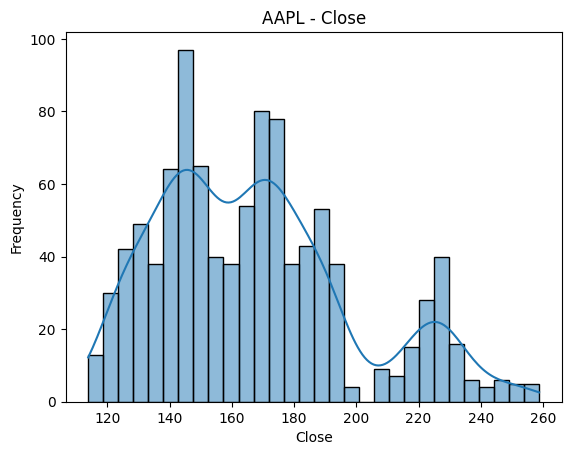

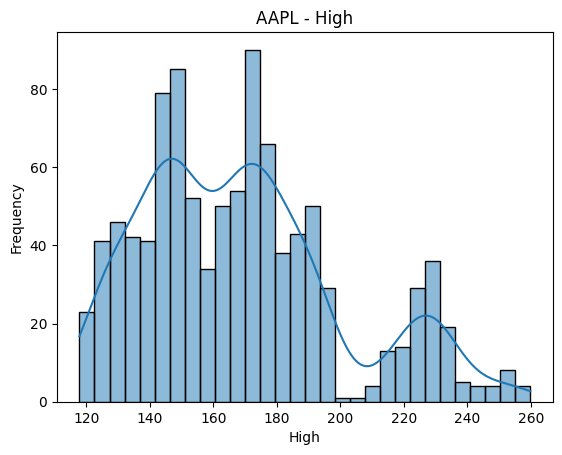

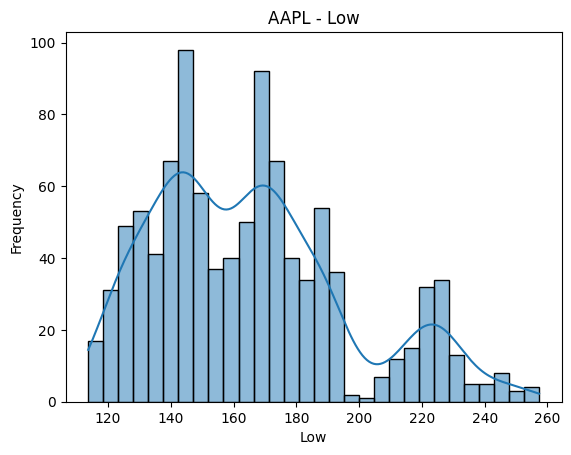

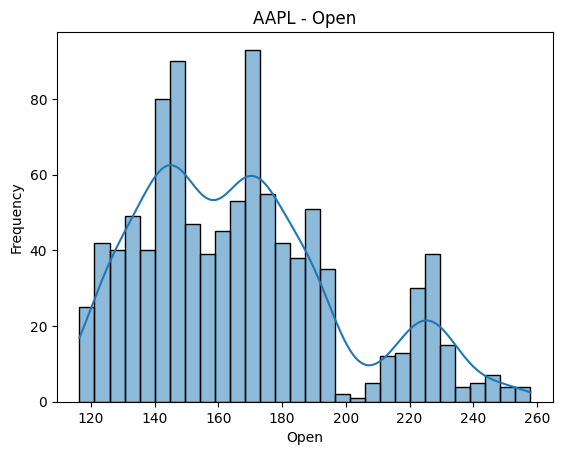

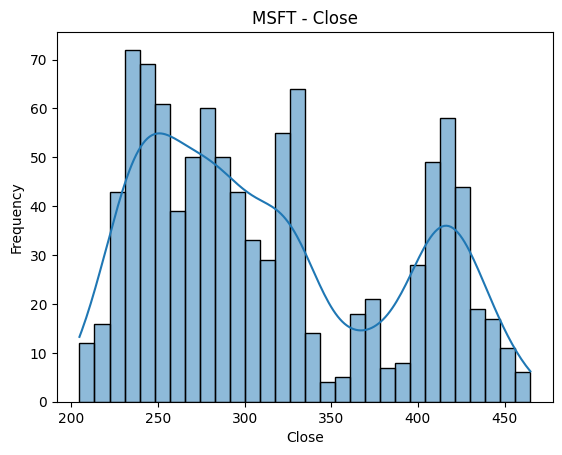

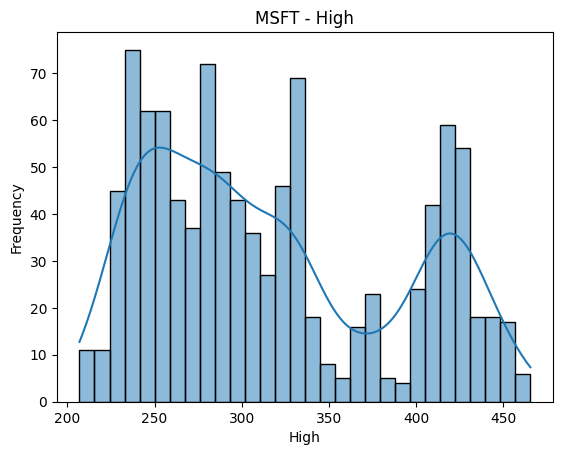

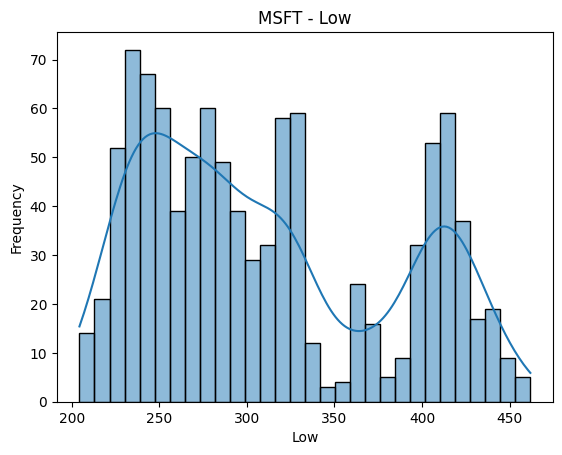

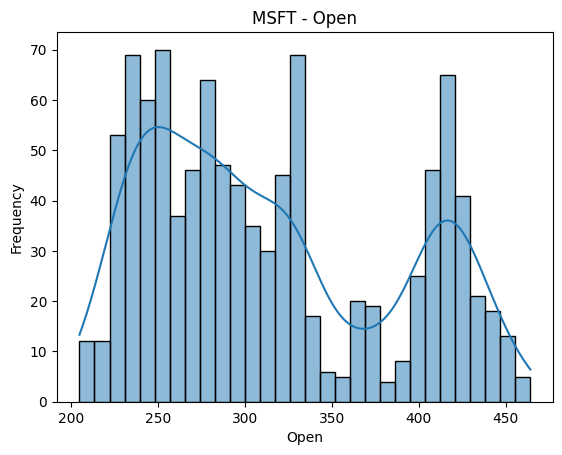

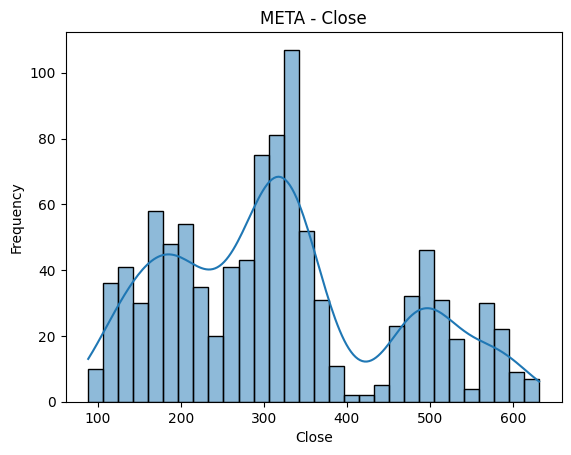

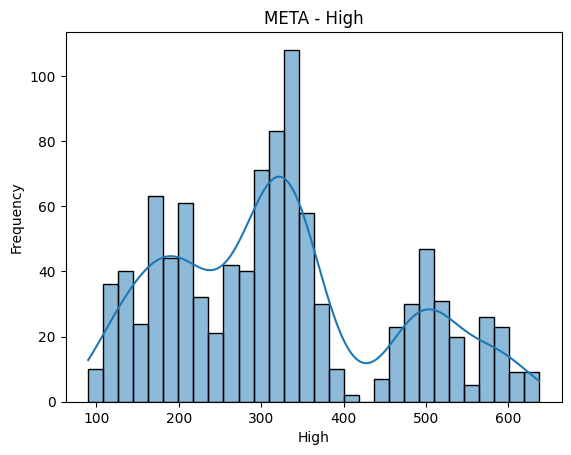

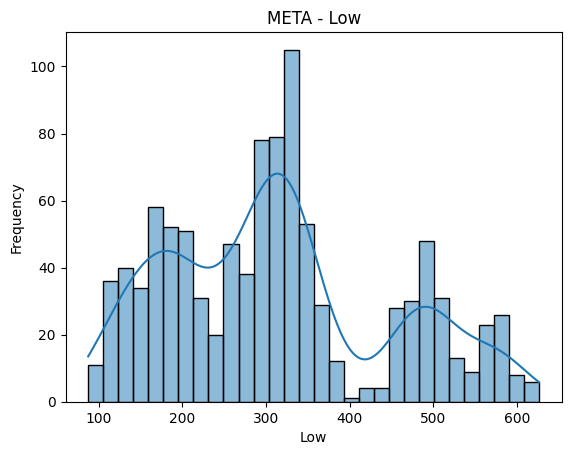

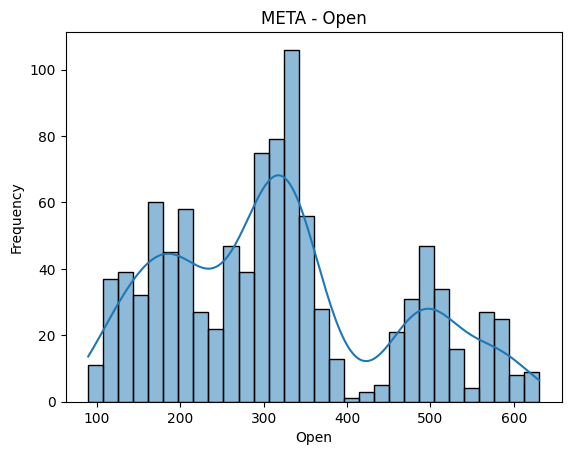

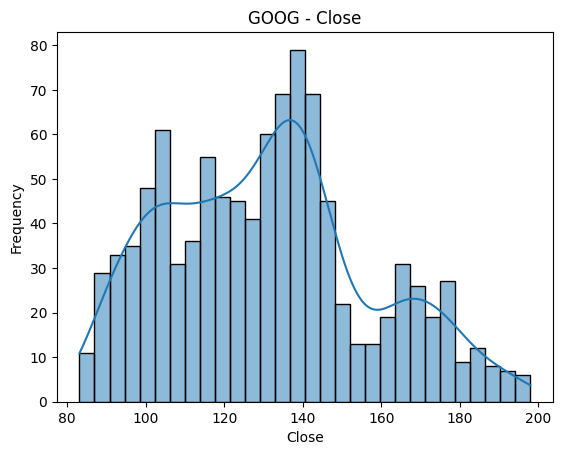

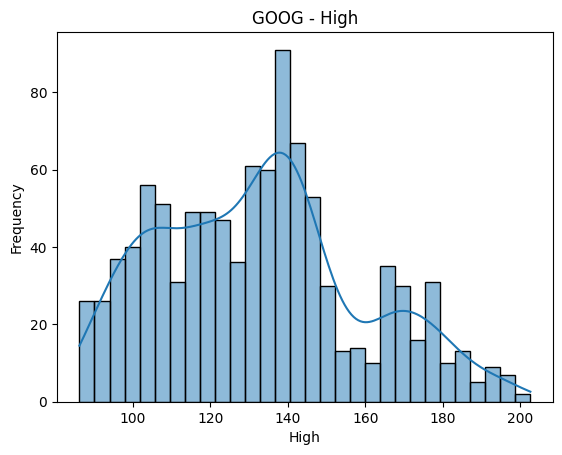

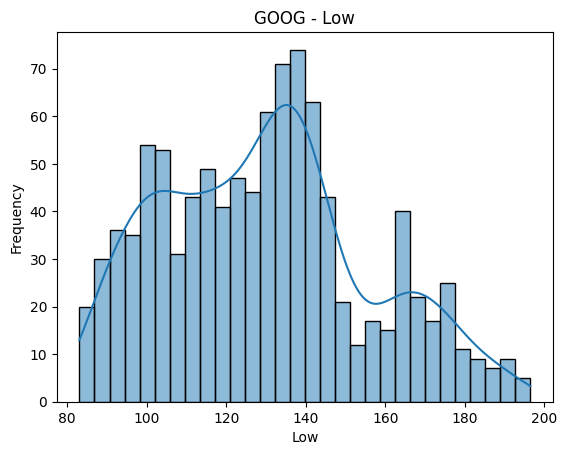

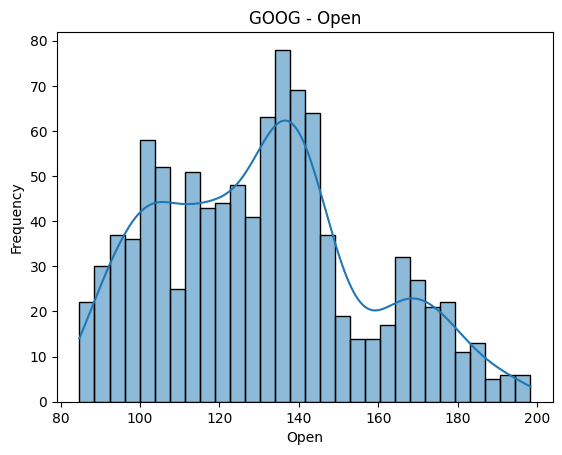

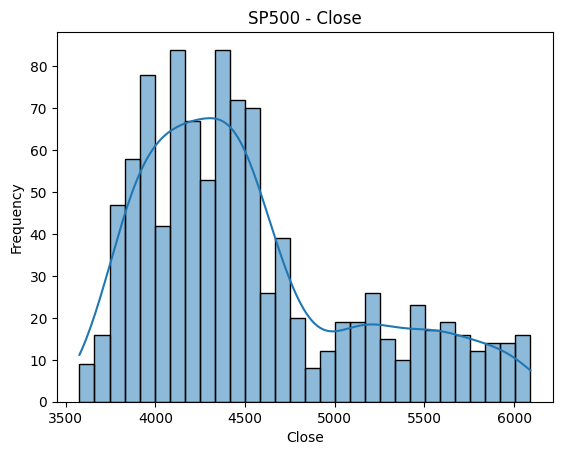

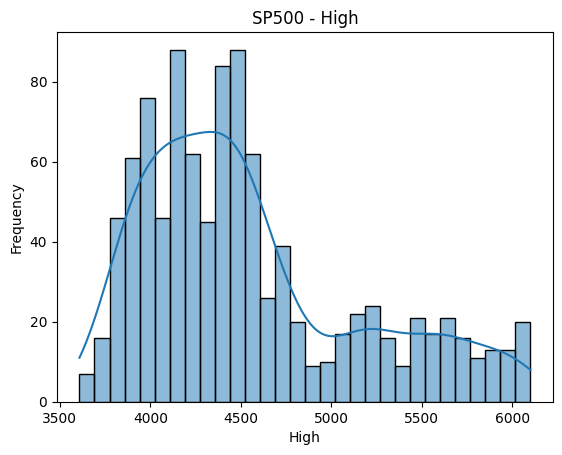

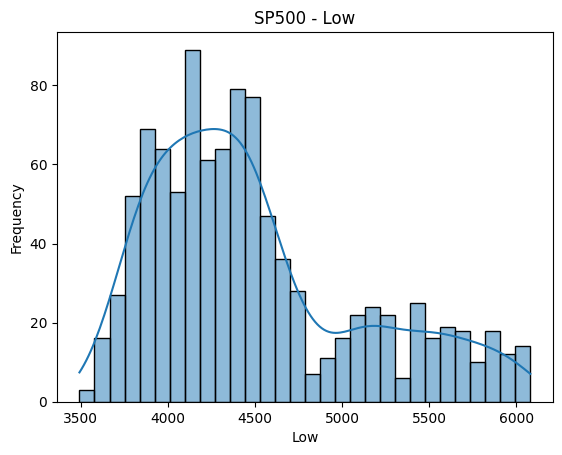

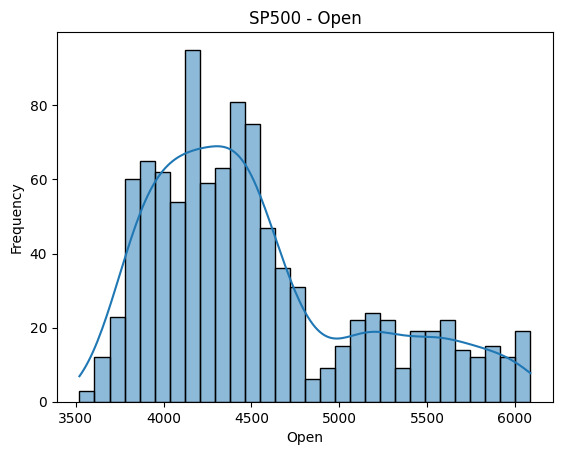

In [269]:
col_names = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
for name, df in named_data.items():
    for i in col_names[1:5]:
        sns.histplot(df[i], bins=30, kde=True)
        plt.title(f"{name} - {i}")
        plt.xlabel(i)
        plt.ylabel("Frequency")
        plt.show()

In [240]:
#sharpe ratio 
def sharpe_ratio_calc(returns, risk_free_rate=0.0):
    excess_return = returns - risk_free_rate
    return np.mean(excess_return) / np.std(excess_return)

In [241]:
sharpe_ratio = {}
for name,df in named_data.items():
    sharpe_ratio_calc
    sharpe_ratio_result = sharpe_ratio_calc(df["Return"],df["daily_rf"])
    sharpe_ratio[name] = sharpe_ratio_result

In [242]:
sharpe_ratio

{'AAPL': np.float64(0.03975756245570354),
 'MSFT': np.float64(0.0428935850935941),
 'META': np.float64(0.03775794755798788),
 'GOOG': np.float64(0.04232543530910059),
 'SP500': np.float64(0.03688255217058566)}

In [243]:
#beta
beta_real = {}
for name,df in named_data.items():
    aligned = pd.concat([
        df['Return'],
        named_data['SP500']['Return']
    ], axis=1).dropna()
    aligned.columns = ['aapl_ret', 'sp500_ret']
    
    cov = np.cov(aligned['aapl_ret'], aligned['sp500_ret'])[0, 1]
    var_market = np.var(aligned['sp500_ret'])
    beta_result = cov / var_market
    beta_real[name] = beta_result

In [244]:
beta_real
#beta of market(sp500) close to 1 means our method used to approx beta is correct

{'AAPL': np.float64(1.2281483309306842),
 'MSFT': np.float64(1.2337917431733747),
 'META': np.float64(1.6563923814515846),
 'GOOG': np.float64(1.3266772542041083),
 'SP500': np.float64(1.0009970089730806)}

In [259]:
#CAPM.(maybe compare with Fama-French late ?)
#CAPM beta
beta_capm = {}
market_return_annual = named_data['SP500']['Return'].mean() * 252
rf_annual = t_bill_3m['T3M'].mean() / 100 

for name,df in named_data.items():   
    stock_return_annual = df['Return'].mean() * 252  
    beta_capm_result = (stock_return_annual - rf_annual) / (market_return_annual - rf_annual)
    beta_capm[name] = beta_capm_result

In [260]:
beta_capm

{'AAPL': np.float64(1.779250554546873),
 'MSFT': np.float64(1.796937564564939),
 'META': np.float64(2.7023436642611296),
 'GOOG': np.float64(2.1842258947109747),
 'SP500': np.float64(1.0)}

In [266]:
for (name1, df1), (name2, df2) in zip(beta_real.items(), beta_capm.items()):
    if name1 == "SP500":
        break
    if(df1 < df2):
        print(f'The stock of {name1} is LESS volatile than the CAPM model predicts. The stock of {name1} may be more stable or less affected by market fluctuations.')
    elif (df1 > df2):
        print(f'The stock of {name1} is MORE volatile than the CAPM model predicts. The stock of {name1} may be less stable in the real world than the prediction of CAPM.')
    else:
         print(f'[{name1}] has beta aligned with CAPM. CAPM perfect predict the model')

The stock of AAPL is LESS volatile than the CAPM model predicts. The stock of AAPL may be more stable or less affected by market fluctuations.
The stock of MSFT is LESS volatile than the CAPM model predicts. The stock of MSFT may be more stable or less affected by market fluctuations.
The stock of META is LESS volatile than the CAPM model predicts. The stock of META may be more stable or less affected by market fluctuations.
The stock of GOOG is LESS volatile than the CAPM model predicts. The stock of GOOG may be more stable or less affected by market fluctuations.
